In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import scipy
import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dataAnalysis.AISolution.simulation.modelLibs import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
colNameBase_TC = "PV - TC Glass [%d,%d]"
colNameBase_PV = "PV - C01_M%02d_Z%02d"
colNameBase_SV = "SV - C01_M%02d_Z%02d"

In [4]:
colNamesSV = [(colNameBase_SV % (h+1, z+1)) for h in range(3) for z in range(22)]
colNamesPV = [(colNameBase_PV % (h+1, z+1)) for h in range(3) for z in range(22)]
colNamesTC = [(colNameBase_TC % (g+1, t+1)) for g in range(2) for t in range(40)]

In [5]:
ioSync = 30
kfold = KFold(n_splits=5, shuffle=True, random_state=56)

In [6]:
TC_SV_Relation = [[20, 22], [19, 20], [19], [18], [17, 18], [17, 21], [6], [6], [10, 12], [8, 10],
                  [8], [8], [6], [4], [2, 4], [8, 9, 10], [6], [9, 10, 11, 12], [7, 9], [7, 8],
                  [7, 8], [5, 6], [5], [3, 4], [1, 2, 3, 4], [11], [7, 9], [7], [7], [5],
                  [3], [1, 3], [5], [5], [16, 22], [15, 16], [15], [14], [13, 14], [13, 21]]

In [7]:
# def KFoldTrain(data, model):
#     mse_list, mae_list, r2_score_list = [], [], []
#     for train_index, test_index in kfold.split(data):
#         x_train, x_test = predTCInp[train_index], predTCInp[test_index]
#         y_train, y_test = predTCOut[train_index], predTCOut[test_index]
#         
#         new_model = model
#         new_model.fit(x_train, y_train)
#         y_pred = new_model.predict(x_test)
#         mse_list.append(mean_squared_error(y_test, y_pred))
#         mae_list.append(mean_absolute_error(y_test, y_pred))
#         r2_score_list.append(r2_score(y_test, y_pred))
#         
#     return mse_list, mae_list, r2_score_list

In [8]:
def splitData(x, y, ratio: tuple):
    r_train, r_test, r_valid = ratio
    r_tot = r_train + r_test + r_valid
    numData = x.shape[0]
    numTrain, numTest = int((r_train / r_tot) * numData), int((r_test / r_tot) * numData)
    
    np.random.seed(56)
    randIdx = np.random.permutation(numData)
    
    idxTrain, idxTestVal = randIdx[:numTrain], randIdx[numTrain:]
    # valid data의 비율이 0일 경우 train data를 제외하고 모두 test data
    if ratio[-1] == 0:
        idxTest = idxTestVal
        (x_train, x_test, y_train, y_test) = (x[idxTrain], x[idxTest], y[idxTrain], y[idxTest])
        return (x_train, x_test, y_train, y_test)
            
    else:
        idxTest, idxValid = (idxTestVal[:numTest], idxTestVal[numTest:])
        (x_train, x_test, x_valid, y_train, y_test, y_valid) = (x[idxTrain], x[idxTest], x[idxValid], y[idxTrain], y[idxTest], y[idxValid])
        return (x_train, x_test, x_valid, y_train, y_test, y_valid)

In [9]:
def check_overfitting(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    val_mse = mean_squared_error(y_val, model.predict(X_val))
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    if val_mse > train_mse * 1.5:  # 임계값은 상황에 따라 조정 가능
        print("과적합의 징후가 있습니다.")
    else:
        print("과적합의 징후가 없습니다.")

### SV와 TC 시점 차이

In [53]:
tmp_df = pd.read_csv("./final_data/2024-06-18 11.13.00_data.csv")
tmp_df["dateTime"] = pd.to_datetime(tmp_df["dateTime"])

In [54]:
sv_data = tmp_df[["dateTime"]+colNamesSV]
tc_data = tmp_df[["dateTime"]+colNamesTC]

In [55]:
sv_data.shape, tc_data.shape

((1801, 67), (1801, 81))

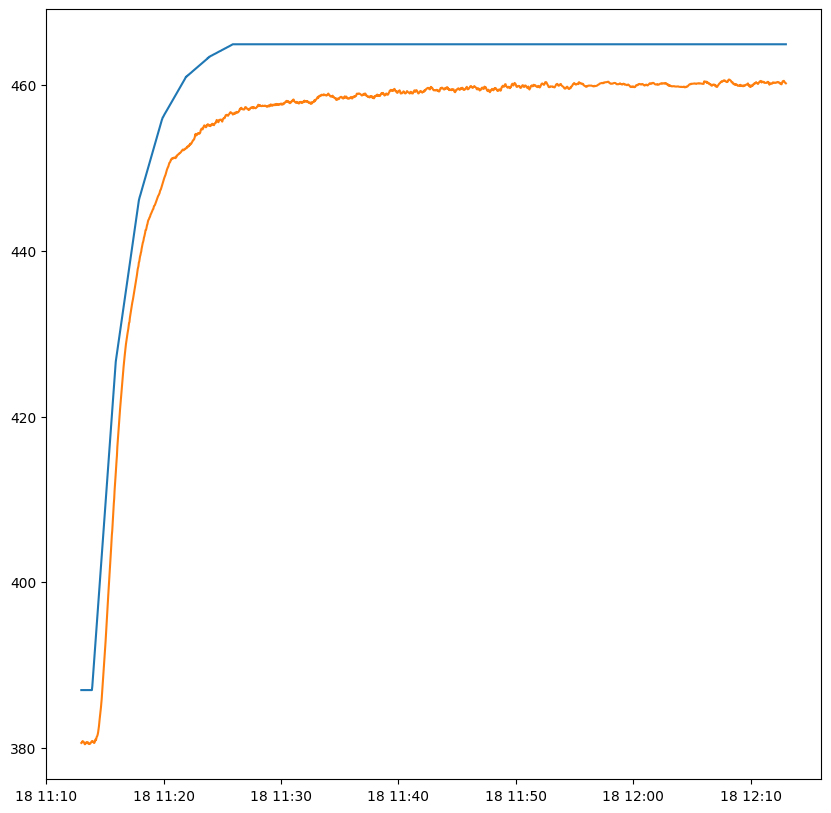

In [56]:
plt.figure(figsize=(10, 10))
plt.plot(sv_data["dateTime"], np.mean(sv_data[colNamesSV], axis=1))
plt.plot(tc_data["dateTime"], np.mean(tc_data[colNamesTC], axis=1))
plt.show()

In [57]:
sv_mean = pd.concat([sv_data["dateTime"], sv_data[colNamesSV].mean(axis=1)], axis=1)
tc_mean = pd.concat([tc_data["dateTime"], tc_data[colNamesTC].mean(axis=1)], axis=1)

In [58]:
sv_mean.to_csv("sv_mean2.csv", index=False)
tc_mean.to_csv("tc_mean2.csv", index=False)

## Slot 1

In [10]:
# colNamesSV1 = [x for x in colNamesSV if "M01" in x]
colNamesTC1 = [x for x in colNamesTC if "[1" in x]

In [11]:
# numSV = len(colNamesSV1)
numSV = len(colNamesSV)
numTC = len(colNamesTC1)

predTCInp = np.empty((0, numSV))
predTCOut = np.empty((0, numTC))

stab_predTCInp = np.empty((0, numSV))
stab_predTCOut = np.empty((0, numTC))

for i, name in enumerate(os.listdir("./final_data/")):
    df = pd.read_csv("./final_data/"+name)
    df["dateTime"] = pd.to_datetime(df["dateTime"])
    date = datetime.datetime.strptime(name, "%Y-%m-%d %H.%M.%S_data.csv")
    start = date + datetime.timedelta(minutes=40)
    end = date + datetime.timedelta(minutes=50)
    stab_df = df[df["dateTime"].between(start, end)]
    
    # dataSV = df[colNamesSV1].to_numpy()
    dataSV = df[colNamesSV].to_numpy()
    dataTC = df[colNamesTC1].to_numpy()
    
    # stab_dataSV = stab_df[colNamesSV1].to_numpy()
    # stab_dataTC = stab_df[colNamesTC1].to_numpy()
    
    predTCInp_tmp = dataSV[:-ioSync, :]
    predTCOut_tmp = dataTC[:-ioSync, :]
    
    # stab_predTCInp_tmp = stab_dataSV[:-ioSync, :]
    # stab_predTCOut_tmp = stab_dataTC[:-ioSync, :]

    predTCInp = np.append(predTCInp, predTCInp_tmp, axis=0)
    predTCOut = np.append(predTCOut, predTCOut_tmp, axis=0)
    
    # stab_predTCInp = np.append(stab_predTCInp, stab_predTCInp_tmp, axis=0)
    # stab_predTCOut = np.append(stab_predTCOut, stab_predTCOut_tmp, axis=0)

In [12]:
(X_train, X_test, y_train, y_test) = splitData(predTCInp, predTCOut, ratio=(8, 2, 0))

### Scaling

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [14]:
robustscaler = RobustScaler()
standardscaler = StandardScaler()

In [15]:
x_train_scaled = standardscaler.fit_transform(X_train)
x_test_scaled = standardscaler.transform(X_test)

### PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=10)

In [18]:
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [19]:
pca.explained_variance_ratio_

array([9.94481658e-01, 4.71322675e-03, 5.47892676e-04, 1.00825331e-04,
       6.59250989e-05, 2.94900966e-05, 2.35946144e-05, 8.68139579e-06,
       7.87349643e-06, 4.39553661e-06])

In [20]:
# 각 축에 대한 가중치
loadings = pd.DataFrame(pca.components_, columns=colNamesSV)
loadings

,SV - C01_M01_Z01,SV - C01_M01_Z02,SV - C01_M01_Z03,SV - C01_M01_Z04,SV - C01_M01_Z05,SV - C01_M01_Z06,SV - C01_M01_Z07,SV - C01_M01_Z08,SV - C01_M01_Z09,SV - C01_M01_Z10,...,SV - C01_M03_Z13,SV - C01_M03_Z14,SV - C01_M03_Z15,SV - C01_M03_Z16,SV - C01_M03_Z17,SV - C01_M03_Z18,SV - C01_M03_Z19,SV - C01_M03_Z20,SV - C01_M03_Z21,SV - C01_M03_Z22
0,-0.122984,-0.123075,-0.122986,-0.123361,-0.122898,-0.122784,-0.123085,-0.123152,-0.123416,-0.123429,...,-0.122451,-0.123425,-0.123426,-0.123400,-0.123425,-0.123424,-0.123426,-0.123425,-0.123390,-0.122709
1,-0.131279,-0.115672,0.135575,-0.010933,0.165442,0.168404,0.127680,0.119378,-0.023499,-0.004042,...,-0.199658,0.018546,0.015641,-0.029172,0.017856,0.019082,0.016157,0.017856,-0.034877,-0.171856
2,-0.173301,-0.146779,0.167423,0.061234,-0.024457,-0.195503,0.061320,0.029758,-0.029179,-0.026820,...,0.291356,0.012074,0.017067,0.074481,0.013261,0.011145,0.016189,0.013261,0.082516,0.215969
3,0.034294,0.178623,0.061896,0.291910,0.041292,0.075028,0.127793,0.039285,-0.034635,-0.004583,...,-0.063810,-0.038801,-0.026948,-0.058560,-0.035987,-0.041002,-0.029083,-0.035987,-0.054585,-0.211536
4,0.112762,0.272367,0.195683,0.284165,0.011754,0.046578,0.094853,-0.094610,0.055330,0.003506,...,0.203708,-0.020909,-0.026869,0.040503,-0.022459,-0.019823,-0.025760,-0.022459,0.043677,0.284809
5,0.274212,0.193616,0.282460,0.041721,0.100205,0.091680,0.053855,0.013001,0.108915,-0.076672,...,-0.156672,-0.023093,-0.012673,-0.073903,-0.020560,-0.025071,-0.014539,-0.020559,-0.072452,-0.168333
6,0.594461,0.341401,0.061610,-0.002513,0.064535,0.102412,-0.340112,0.022122,-0.043821,0.002753,...,0.037932,0.001311,0.005768,0.024898,0.002620,0.000952,0.005408,0.002620,0.029471,0.035073
7,-0.029050,0.104161,-0.421157,-0.099595,0.106379,0.475627,0.188567,0.014860,-0.058111,-0.088863,...,0.210508,-0.026753,-0.034150,0.032773,-0.028331,-0.024880,-0.032113,-0.028330,0.031480,0.037239
8,-0.016237,0.036897,0.090747,-0.209992,0.037152,0.237313,0.179535,-0.169783,-0.102491,0.017975,...,0.296751,-0.033256,-0.036704,0.135430,-0.034169,-0.032947,-0.036220,-0.034168,0.147254,-0.092917
9,0.154208,-0.081499,-0.085285,0.037495,-0.383178,-0.216382,0.010170,0.078599,0.166390,-0.001997,...,0.134687,0.004197,0.003838,0.166861,0.006265,0.005619,0.005057,0.006264,0.183902,-0.496481


In [21]:
abs(loadings)

,SV - C01_M01_Z01,SV - C01_M01_Z02,SV - C01_M01_Z03,SV - C01_M01_Z04,SV - C01_M01_Z05,SV - C01_M01_Z06,SV - C01_M01_Z07,SV - C01_M01_Z08,SV - C01_M01_Z09,SV - C01_M01_Z10,...,SV - C01_M03_Z13,SV - C01_M03_Z14,SV - C01_M03_Z15,SV - C01_M03_Z16,SV - C01_M03_Z17,SV - C01_M03_Z18,SV - C01_M03_Z19,SV - C01_M03_Z20,SV - C01_M03_Z21,SV - C01_M03_Z22
0,0.122984,0.123075,0.122986,0.123361,0.122898,0.122784,0.123085,0.123152,0.123416,0.123429,...,0.122451,0.123425,0.123426,0.123400,0.123425,0.123424,0.123426,0.123425,0.123390,0.122709
1,0.131279,0.115672,0.135575,0.010933,0.165442,0.168404,0.127680,0.119378,0.023499,0.004042,...,0.199658,0.018546,0.015641,0.029172,0.017856,0.019082,0.016157,0.017856,0.034877,0.171856
2,0.173301,0.146779,0.167423,0.061234,0.024457,0.195503,0.061320,0.029758,0.029179,0.026820,...,0.291356,0.012074,0.017067,0.074481,0.013261,0.011145,0.016189,0.013261,0.082516,0.215969
3,0.034294,0.178623,0.061896,0.291910,0.041292,0.075028,0.127793,0.039285,0.034635,0.004583,...,0.063810,0.038801,0.026948,0.058560,0.035987,0.041002,0.029083,0.035987,0.054585,0.211536
4,0.112762,0.272367,0.195683,0.284165,0.011754,0.046578,0.094853,0.094610,0.055330,0.003506,...,0.203708,0.020909,0.026869,0.040503,0.022459,0.019823,0.025760,0.022459,0.043677,0.284809
5,0.274212,0.193616,0.282460,0.041721,0.100205,0.091680,0.053855,0.013001,0.108915,0.076672,...,0.156672,0.023093,0.012673,0.073903,0.020560,0.025071,0.014539,0.020559,0.072452,0.168333
6,0.594461,0.341401,0.061610,0.002513,0.064535,0.102412,0.340112,0.022122,0.043821,0.002753,...,0.037932,0.001311,0.005768,0.024898,0.002620,0.000952,0.005408,0.002620,0.029471,0.035073
7,0.029050,0.104161,0.421157,0.099595,0.106379,0.475627,0.188567,0.014860,0.058111,0.088863,...,0.210508,0.026753,0.034150,0.032773,0.028331,0.024880,0.032113,0.028330,0.031480,0.037239
8,0.016237,0.036897,0.090747,0.209992,0.037152,0.237313,0.179535,0.169783,0.102491,0.017975,...,0.296751,0.033256,0.036704,0.135430,0.034169,0.032947,0.036220,0.034168,0.147254,0.092917
9,0.154208,0.081499,0.085285,0.037495,0.383178,0.216382,0.010170,0.078599,0.166390,0.001997,...,0.134687,0.004197,0.003838,0.166861,0.006265,0.005619,0.005057,0.006264,0.183902,0.496481


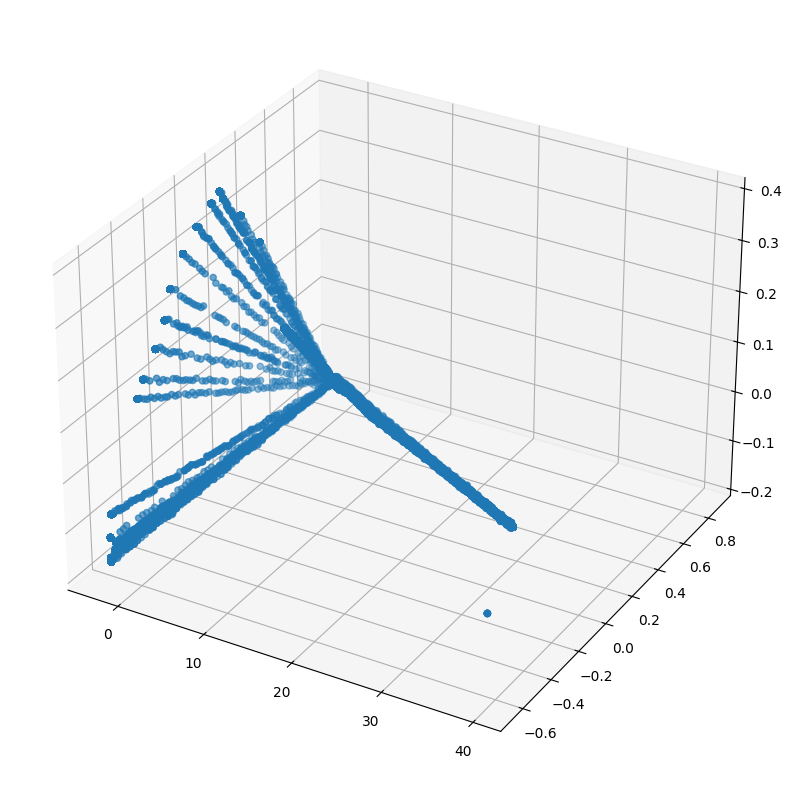

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_train_pca[:,0], x_train_pca[:,1], x_train_pca[:,2])
plt.show()

직교하는 축 직접 구하기

In [33]:
from scipy.linalg import svd, null_space

In [34]:
pca = PCA(n_components=1)

In [27]:
first_pc = pca.components_[0]
first_pc

array([-0.12298365, -0.12307507, -0.12298629, -0.12336062, -0.12289838,
       -0.12278409, -0.12308498, -0.12315153, -0.12341572, -0.12342944,
       -0.12340643, -0.12268516, -0.12293833, -0.12310105, -0.12304161,
       -0.12027174, -0.12311773, -0.1228311 , -0.12206623, -0.12338705,
       -0.12214311, -0.12277661, -0.12336372, -0.1234095 , -0.12308353,
       -0.12342103, -0.12341932, -0.12341844, -0.12340194, -0.12342756,
       -0.12335936, -0.1234059 , -0.12301881, -0.12294705, -0.12342989,
       -0.12332927, -0.12342874, -0.12340944, -0.12339572, -0.12333717,
       -0.12333897, -0.1233096 , -0.12293858, -0.11809899, -0.12338394,
       -0.12342531, -0.12342449, -0.12342538, -0.12342515, -0.12342555,
       -0.12342699, -0.12342379, -0.1232266 , -0.12333749, -0.12340989,
       -0.12341181, -0.12245144, -0.12342461, -0.12342621, -0.12339977,
       -0.12342513, -0.12342417, -0.12342602, -0.12342513, -0.12338966,
       -0.12270917])

In [28]:
orthogonal_space = null_space(first_pc.reshape(1, -1))

In [29]:
orthogonal_space

array([[-0.12307507, -0.12298629, -0.12336062, ..., -0.12342513,
        -0.12338966, -0.12270917],
       [ 0.9865114 , -0.01347887, -0.01351989, ..., -0.01352696,
        -0.01352307, -0.01344849],
       [-0.01347887,  0.98653086, -0.01351014, ..., -0.0135172 ,
        -0.01351332, -0.01343879],
       ...,
       [-0.01352696, -0.0135172 , -0.01355834, ...,  0.98643457,
        -0.01356154, -0.01348675],
       [-0.01352307, -0.01351332, -0.01355445, ..., -0.01356154,
         0.98644236, -0.01348287],
       [-0.01344849, -0.01343879, -0.0134797 , ..., -0.01348675,
        -0.01348287,  0.98659149]])

In [30]:
pca_orthogonal = PCA(n_components=1)
pca_orthogonal.fit(np.dot(x_train_scaled, orthogonal_space))

PCA(n_components=1)

In [32]:
pca_orthogonal.components_

array([[-0.10128428,  0.14995232,  0.00348792,  0.17980871,  0.18275719,
         0.14206886,  0.13377462, -0.00907108,  0.01038697, -0.00584692,
        -0.18042584,  0.17321267,  0.08653602,  0.14097738,  0.41368014,
         0.03466651,  0.12317555,  0.26912293,  0.0566392 ,  0.26278501,
        -0.15716663, -0.0392726 , -0.01526844, -0.11418769,  0.02192138,
        -0.00153176,  0.01535763, -0.01511859,  0.01489928, -0.04191294,
         0.03708808, -0.12873176, -0.14030027,  0.01034168,  0.07822202,
         0.00775657, -0.00387415, -0.02371331,  0.07646319,  0.07941291,
         0.08838246, -0.14070325, -0.48377857, -0.02314097,  0.03195442,
         0.03314439,  0.03187449,  0.03225491,  0.03158928,  0.01382645,
         0.0339425 , -0.07351666, -0.04288071, -0.00839487, -0.0073681 ,
        -0.18534339,  0.03297487,  0.03006959, -0.01474607,  0.03228453,
         0.03351095,  0.03058591,  0.03228447, -0.02045263, -0.15751134]])

In [31]:
second_pc = pca_orthogonal.components_[0]
second_pc

array([-0.10128428,  0.14995232,  0.00348792,  0.17980871,  0.18275719,
        0.14206886,  0.13377462, -0.00907108,  0.01038697, -0.00584692,
       -0.18042584,  0.17321267,  0.08653602,  0.14097738,  0.41368014,
        0.03466651,  0.12317555,  0.26912293,  0.0566392 ,  0.26278501,
       -0.15716663, -0.0392726 , -0.01526844, -0.11418769,  0.02192138,
       -0.00153176,  0.01535763, -0.01511859,  0.01489928, -0.04191294,
        0.03708808, -0.12873176, -0.14030027,  0.01034168,  0.07822202,
        0.00775657, -0.00387415, -0.02371331,  0.07646319,  0.07941291,
        0.08838246, -0.14070325, -0.48377857, -0.02314097,  0.03195442,
        0.03314439,  0.03187449,  0.03225491,  0.03158928,  0.01382645,
        0.0339425 , -0.07351666, -0.04288071, -0.00839487, -0.0073681 ,
       -0.18534339,  0.03297487,  0.03006959, -0.01474607,  0.03228453,
        0.03351095,  0.03058591,  0.03228447, -0.02045263, -0.15751134])

In [26]:
second_pc_original = np.dot(second_pc, orthogonal_space.T)

In [31]:
first_pc_components = pca.components_
second_pc_components = pca_orthogonal.components_

In [32]:
new_data1 = np.dot(x_train_scaled, first_pc_components.T)
new_data2 = np.dot(x_train_scaled, second_pc_components.T)

ValueError: shapes (70831,66) and (65,1) not aligned: 66 (dim 1) != 65 (dim 0)

### t-SNE

In [56]:
from sklearn.manifold import TSNE

In [57]:
tsne = TSNE(n_components=3, verbose=1, perplexity=200)

In [58]:
x_train_tsne = tsne.fit_transform(x_train_pca)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 70831 samples in 0.005s...
[t-SNE] Computed neighbors for 70831 samples in 4.951s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70831
[t-SNE] Computed conditional probabilities for sample 2000 / 70831
[t-SNE] Computed conditional probabilities for sample 3000 / 70831
[t-SNE] Computed conditional probabilities for sample 4000 / 70831
[t-SNE] Computed conditional probabilities for sample 5000 / 70831
[t-SNE] Computed conditional probabilities for sample 6000 / 70831
[t-SNE] Computed conditional probabilities for sample 7000 / 70831
[t-SNE] Computed conditional probabilities for sample 8000 / 70831
[t-SNE] Computed conditional probabilities for sample 9000 / 70831
[t-SNE] Computed conditional probabilities for sample 10000 / 70831
[t-SNE] Computed conditional probabilities for sample 11000 / 70831
[t-SNE] Computed conditional probabilities for sample 12000 / 70831
[t-SNE] Computed conditional probabilities for sa

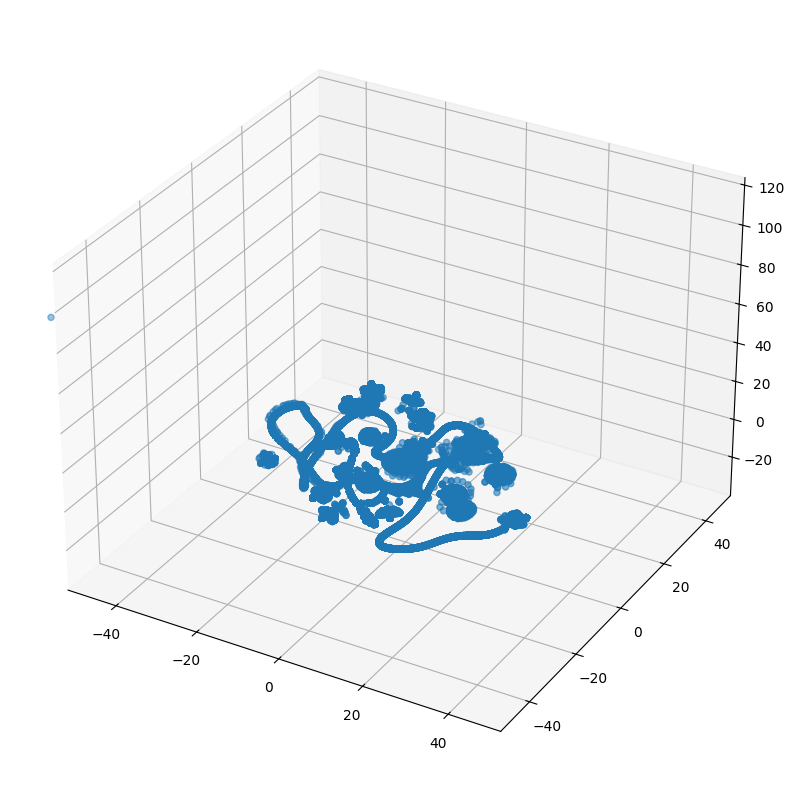

In [60]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_train_tsne[:,0], x_train_tsne[:,1], x_train_tsne[:,2])
plt.xlim([-50,50])
plt.ylim([-50,50])
plt.show()

In [ ]:
(x_train, x_test, y_train, y_test) = splitData(x_train_tsne, predTCOut, ratio=(8, 2, 0))

RandomForest

In [22]:
RandomRegTC = RandomForest('TC', dataType='tabular')
RandomRegTC.fit(x_train_pca, y_train)
y_pred = RandomRegTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

6.4539560870844355
1.5119830643464112
0.9760655375792234


In [23]:
y_pred

array([[459.6321572 , 457.50820723, 458.75496754, ..., 460.28745721,
        460.5672885 , 458.99723008],
       [459.40278145, 457.39977542, 460.60232782, ..., 459.56818583,
        460.97094301, 459.18660418],
       [447.31733333, 450.42451411, 459.22933333, ..., 460.95733333,
        457.46733333, 453.02666667],
       ...,
       [458.96511868, 457.28407448, 460.40676988, ..., 459.49264742,
        460.63576471, 458.03189829],
       [459.43381466, 457.89199638, 463.24929587, ..., 461.01731828,
        461.74198107, 459.23768848],
       [459.40278145, 457.39977542, 460.60232782, ..., 459.56818583,
        460.97094301, 459.18660418]])

In [24]:
X_test2 = X_test.copy()
X_test2[:10] = X_test[:10] + 200
x_test2_scaled = standardscaler.transform(X_test2)
x_test2_pca = pca.transform(x_test2_scaled)

In [25]:
y_pred2 = RandomRegTC.predict(x_test2_pca)
y_pred2

array([[449.3879785 , 449.25554684, 452.30387271, ..., 452.41384102,
        451.73762805, 449.06444382],
       [449.31421453, 449.21080303, 452.31209131, ..., 452.63822635,
        451.62856904, 448.73166554],
       [448.88669621, 449.23051376, 452.62701856, ..., 452.45275971,
        451.44832836, 448.60219035],
       ...,
       [458.96511868, 457.28407448, 460.40676988, ..., 459.49264742,
        460.63576471, 458.03189829],
       [459.43381466, 457.89199638, 463.24929587, ..., 461.01731828,
        461.74198107, 459.23768848],
       [459.40278145, 457.39977542, 460.60232782, ..., 459.56818583,
        460.97094301, 459.18660418]])

In [0]:
# mse_list = []
# mae_list = []
# r2_score_list = []
# deviation_list = []
# for train_index, test_index in kfold.split(X_pca):
#     x_train, x_test = X_pca[train_index], X_pca[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
# 
#     RandomRegTC = RandomForest('TC', dataType='tabular')
#     RandomRegTC.fit(x_train, y_train)
#     y_pred = RandomRegTC.predict(x_test)
#     mse_list.append(mean_squared_error(y_test, y_pred))
#     mae_list.append(mean_absolute_error(y_test, y_pred))
#     r2_score_list.append(r2_score(y_test, y_pred))
# 
# mse = np.mean(mse_list)
# mae = np.mean(mae_list)
# r2 = np.mean(r2_score_list)
# print(f"mse-{mse:0.4f}\nmae-{mae:0.4f}\nr2_score-{r2:0.4f}")

Linear Regression

In [26]:
LinearRegTC = LinearRegressor('TC', dataType='tabular')
LinearRegTC.fit(x_train_pca, y_train)
y_pred = LinearRegTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

276.6888487654558
9.140867153804349
0.005211175926509265


In [28]:
y_pred

array([[451.83238595, 451.9378305 , 453.60196782, ..., 454.34280038,
        454.69312304, 452.95722146],
       [453.63935916, 451.98670759, 455.41653652, ..., 455.85759011,
        455.63161186, 453.34932756],
       [452.01196558, 451.94268798, 458.51479805, ..., 458.44399798,
        457.23402229, 453.5007231 ],
       ...,
       [453.60364767, 451.98574162, 455.58213654, ..., 455.99583189,
        455.71725963, 453.36305623],
       [451.95128622, 451.94104665, 458.81683092, ..., 458.69613298,
        457.39023267, 453.52625203],
       [453.63935916, 451.98670759, 455.41653652, ..., 455.85759011,
        455.63161186, 453.34932756]])

In [0]:
# mse_list = []
# mae_list = []
# r2_score_list = []
# deviation_list = []
# for train_index, test_index in kfold.split(X_pca):
#     x_train, x_test = X_pca[train_index], X_pca[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
# 
#     LinearRegTC = LinearRegressor('TC', dataType='tabular')
#     LinearRegTC.fit(x_train, y_train)
#     y_pred = LinearRegTC.predict(x_test)
#     mse_list.append(mean_squared_error(y_test, y_pred))
#     mae_list.append(mean_absolute_error(y_test, y_pred))
#     r2_score_list.append(r2_score(y_test, y_pred))
# 
# mse = np.mean(mse_list)
# mae = np.mean(mae_list)
# r2 = np.mean(r2_score_list)
# print(f"mse-{mse:0.4f}\nmae-{mae:0.4f}\nr2_score-{r2:0.4f}")

### Lasso Regression

In [27]:
LassoRegTC = LassoRegressor('TC', dataType='tabular')
LassoRegTC.fit(x_train_pca, y_train)
y_pred = LassoRegTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

276.7900749687669
9.166220279771334
0.004848926671238022


### Ridge Regression

In [28]:
RidgeRegTC = RidgeRegressor('TC', dataType='tabular')
RidgeRegTC.fit(x_train_pca, y_train)
y_pred = RidgeRegTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

276.75711032730425
9.153548038017828
0.004962378911399487


### XGBoost

In [29]:
XGBoostTC = XGBoost('TC', dataType='tabular')
XGBoostTC.fit(x_train_pca, y_train)
y_pred = XGBoostTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

6.625583883751955
1.6030731853536004
0.9755209682040696


### KNN Regression

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF

In [31]:
kernel = 1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
KNNRegressTC = KNeighborsRegressor(n_neighbors=3, weights="distance")
KNNRegressTC.fit(x_train_pca, y_train)
y_pred = KNNRegressTC.predict(x_test_pca)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

8.496444358135967
1.742972301373122
0.9684912773305758


In [32]:
y_pred = KNNRegressTC.predict(x_test_pca)
y_pred

array([[459.6       , 457.87418594, 458.43333333, ..., 460.03333333,
        460.86666667, 458.96666667],
       [458.76666667, 457.39003227, 460.3       , ..., 459.4       ,
        461.        , 458.2       ],
       [447.3       , 450.45487856, 459.3       , ..., 460.86666667,
        457.43333333, 453.06666667],
       ...,
       [458.89999987, 457.2392474 , 459.9999999 , ..., 459.29999993,
        460.23333321, 457.46666638],
       [459.9       , 458.43505585, 463.46666667, ..., 460.96666667,
        461.86666667, 459.46666667],
       [458.76666667, 457.39003227, 460.3       , ..., 459.4       ,
        461.        , 458.2       ]])

In [33]:
X_test2 = X_test.copy()
X_test2[:10] = X_test[:10] + 200
x_test2_scaled = standardscaler.transform(X_test2)
x_test2_pca = pca.transform(x_test2_scaled)

In [34]:
y_pred2 = KNNRegressTC.predict(x_test2_pca)
y_pred2

array([[458.26666667, 456.92846643, 457.46666667, ..., 458.76666667,
        459.        , 456.06666667],
       [458.26666667, 456.92846643, 457.46666667, ..., 458.76666667,
        459.        , 456.06666667],
       [458.26666667, 456.92846643, 457.46666667, ..., 458.76666667,
        459.        , 456.06666667],
       ...,
       [458.89999987, 457.2392474 , 459.9999999 , ..., 459.29999993,
        460.23333321, 457.46666638],
       [459.9       , 458.43505585, 463.46666667, ..., 460.96666667,
        461.86666667, 459.46666667],
       [458.76666667, 457.39003227, 460.3       , ..., 459.4       ,
        461.        , 458.2       ]])